# Mobile price classification with multilayer perceptron
## PyTorch
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

### 0. Imports

In [25]:
import wandb
from pprint import pprint
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import split_train_val
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


In [26]:
wandb.login()

api = wandb.Api()
sweep = api.sweep("xmatovice/uncategorized/1stel95e")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='uncategorized', name='NSIETE_zad1_final')
config = wandb.config

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Sorting runs by -summary_metrics.validation_accuracy


{'batch_size': 128,
 'dense1': 256,
 'epochs': 100,
 'learning_rate': 0.03648030109469176}


### 2. Data transformation
 - no null values
 - load train and test datasets & from test dataset make validation and test dataset

In [27]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_test = df_train[-200:]
df_train = df_train[:-200]
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,527,0,0.7,1,4,0,53,0.9,128,1,...,67,1924,1302,13,7,13,0,0,0,0
1796,793,1,2.8,1,1,1,64,0.4,179,4,...,818,1006,2296,12,0,5,1,1,0,1
1797,873,1,0.5,1,6,0,8,0.6,152,7,...,1257,1411,575,15,8,7,1,0,1,0
1798,722,0,1.1,0,12,0,12,1.0,93,6,...,138,1371,2359,13,6,3,0,0,0,1


In [28]:
df_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1800,1358,0,1.7,0,0,0,60,0.6,147,3,...,889,1635,440,14,10,13,1,0,0,0
1801,1035,1,1.9,1,8,0,11,1.0,173,6,...,831,1709,2002,17,8,5,1,1,0,1
1802,1289,0,0.8,1,3,1,16,0.9,161,6,...,713,1854,3167,14,8,20,1,1,0,3
1803,1445,0,2.2,1,2,0,37,0.4,82,2,...,527,1393,3480,17,16,17,1,1,1,3
1804,1702,1,2.3,1,12,1,47,0.6,107,2,...,1284,1643,595,10,0,19,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [29]:
X_train = df_train.values[:, :-1]       # store the inputs
X_train = X_train.astype('float32')     # input data as floats
X_train

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [8.730e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [7.220e+02, 0.000e+00, 1.100e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.250e+03, 1.000e+00, 1.500e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [30]:
X_test = df_test.values[:, :-1]       # store the inputs
X_test = X_test.astype('float32')     # input data as floats
X_test

array([[1.358e+03, 0.000e+00, 1.700e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.035e+03, 1.000e+00, 1.900e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.289e+03, 0.000e+00, 8.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [31]:
y_train = df_train.values[:, -1]  # store the outputs
y_train = y_train.astype('int')     # input data as floats
y_train

array([1, 2, 2, ..., 0, 1, 2])

In [32]:
y_test = df_test.values[:, -1]  # store the outputs
y_test = y_test.astype('int')     # input data as floats
y_test

array([0, 1, 3, 3, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 0, 2, 0, 3,
       1, 2, 2, 1, 2, 3, 3, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2, 3, 0, 0, 3,
       0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 3, 0, 2,
       3, 2, 3, 3, 2, 3, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 3, 0, 1, 2,
       0, 3, 1, 0, 0, 3, 0, 1, 0, 3, 3, 0, 1, 2, 2, 2, 3, 0, 1, 3, 3, 1,
       3, 0, 1, 0, 0, 2, 1, 0, 2, 0, 3, 1, 0, 2, 1, 2, 1, 3, 0, 2, 3, 1,
       1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 1, 3,
       0, 3, 0, 3, 3, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 3, 1, 3,
       0, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 0, 1, 1, 0, 3, 0, 3, 3, 0, 2, 3,
       0, 3])

In [33]:
# make dataset from X and y
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
train_ds

In [34]:
# make dataset from X and y
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))
test_ds

In [35]:
batch_size = best_config['batch_size']
tf_train, tf_val = split_train_val(train_ds)

print(tf_train.dataset)
print(tf_val.dataset)

In [36]:
train_dl = DataLoader(tf_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(tf_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0) #.astype('float32')

print(len(train_dl.dataset))
print(len(val_dl.dataset))
print(len(test_dl.dataset))

print(train_dl.dataset)
print(val_dl.dataset)
print(test_dl.dataset)

1620
180
200


In [37]:
train_dl.dataset

## Model

In [38]:
class MLP(nn.Module):
    """ 
    Model class.
    :param Module from torch.nn
    """
    def __init__(self, n_inputs: int, n_classes: int, lr: float, hidden_size: float) -> None:
        """
        Model elements init.
        """
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.n_classes = n_classes
        self.lr = lr
        self.hidden_size = hidden_size
    
        # input to first hidden layer
        # pridať hlbku aj šírku siete
        # skúsiť normalizovať dáta
        self.dense1 = nn.Linear(n_inputs, self.hidden_size)
        # second hidden layer
        self.dense2 = nn.Linear(self.hidden_size, self.hidden_size)
        # third hidden layer and output
        self.dense3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense4 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense5 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense6 = nn.Linear(self.hidden_size, self.n_classes)
        
        # activation f
        self.relu = nn.ReLU()
        # prv začat bez dropout, ptm pridat, pozrieť sa na parametre 
        # dropout pomaha proti preuceniu
        self.droput = nn.Dropout(p=0.05)
 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        """
        Feed forward
        """
        # print(type(X))
        #print(self.n_inputs)
        # input to first hidden layer
        output = self.dense1(X)
        output = self.relu(output)
        output = self.droput(output)
        
        # second hidden layer
        output = self.dense2(output)
        output = self.relu(output)
        output = self.droput(output)

        # third hidden layer
        output = self.dense3(output)
        output = self.relu(output)
        output = self.droput(output)
        
        # second hidden layer
        output = self.dense4(output)
        output = self.relu(output)
        output = self.droput(output)
        
        # second hidden layer
        output = self.dense5(output)
        output = self.relu(output)
        output = self.droput(output)

        # final layer and output
        output = self.dense6(output)
        # print(type(output))

        # print(type(output))
        return output

In [39]:
learning_rate = best_config['learning_rate']    #  # 0.001 
input_size = 20                         # number of features
hidden_size = best_config['dense1']        #  #64         # number of features in hidden state
num_classes = 4                 # number of output classes 

n_epochs = best_config['epochs']        
batch_size = 512  

mlp = MLP( 
    n_inputs=input_size, 
    n_classes=num_classes,
    lr=learning_rate,
    hidden_size=hidden_size)
mlp.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

In [40]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    return correct


def train_mlp(n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, batch_size):
    # init train lists for statistics
    loss_train, accuracy_train = list(), list()

    # init validation lists for statistics
    loss_validation, accuracy_validation = list(), list()

    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy, epoch_train_total, epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        # init epoch validation counters
        epoch_validation_accuracy, epoch_validation_total, \
            epoch_validation_true, epoch_validation_loss = 0, 0, 0, 0

        # enumerate mini batches
        for idx, (X_batch, y_batch) in enumerate(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            # Make prediction logits with model
            y_logits = mlp(X_batch)
            # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
            y_pred_probs = torch.softmax(y_logits, dim=1) 
            # go from logits -> prediction probabilities -> prediction labels
            y_pred = torch.argmax(y_pred_probs, dim=1) 
            
            loss = loss_fn(y_logits, y_batch)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()
            epoch_train_true += accuracy_fn(y_batch, y_pred)
            epoch_train_total += len(y_batch)
        
        # update train accuracy & loss statistics
        epoch_train_accuracy = (epoch_train_true/epoch_train_total) * 100
        epoch_train_loss /= (len(train_dl.dataset)/train_dl.batch_size) #batch_size)

        # disable gradient calculation
        with torch.no_grad():
            # enumerate mini batches
            for idx, (X_batch, y_batch) in enumerate(val_dl):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute the models output
                test_logits = mlp(X_batch)
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                # calculate loss
                loss = loss_fn(test_logits, y_batch)

                # update validation counters
                epoch_validation_loss += loss.item()
                epoch_validation_true += accuracy_fn(y_batch, test_pred)
                epoch_validation_total += len(y_batch)
        
        # update validation accuracy & loss statistics
        epoch_validation_accuracy = (epoch_validation_true/epoch_validation_total) * 100
        epoch_validation_loss /= (len(val_dl.dataset)/val_dl.batch_size) #batch_size)

        # update global epochs statistics
        loss_train.append(epoch_train_loss)
        accuracy_train.append(epoch_train_accuracy)
        loss_validation.append(epoch_validation_loss)
        accuracy_validation.append(epoch_validation_accuracy)

        # print
        if epoch == (n_epochs - 1):
            print(
                f'Epoch {epoch}/{n_epochs}: \
                train loss {loss_train[-1]}, \
                validation loss {loss_validation[-1]}, \
                train accuracy {accuracy_train[-1]}, \
                validation accuracy {accuracy_validation[-1]}'
            )

    return loss_train, accuracy_train, loss_validation, accuracy_validation

In [41]:
def evaluation(mlp, test_dl):

    y_pred_all, y_test_all = list(), list()

    #total = 0
    #correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dl:
            # outputs = mlp(X_batch)
            # evaluate on test set
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_hat = mlp(X_batch)
            test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
            epoch_validation_true += accuracy_fn(y_batch, test_pred)
            
            y_pred_all.extend(test_pred.cpu().numpy())
            y_test_all.extend(y_batch.cpu().numpy())
        epoch_validation_true = (epoch_validation_true / len(test_dl.dataset)) * 100
    
    print('acc:', epoch_validation_true)
    report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], digits=4)
    print(report)

In [42]:
loss_train, accuracy_train, loss_validation, accuracy_validation = \
    train_mlp(
        n_epochs=n_epochs,
        mlp=mlp,
        optimizer=optimizer,
        loss_fn=loss_fn,
        train_dl=train_dl,
        val_dl=val_dl,
        device=device,
        batch_size=batch_size
    )

Epoch 99/100:                 train loss 0.6336436424726322,                 validation loss 0.7231514400906033,                 train accuracy 75.4320987654321,                 validation accuracy 82.22222222222221


In [43]:
y_pred_all, y_test_all = list(), list()

total = 0
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_hat = mlp(X_batch)
        test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
        epoch_validation_true = accuracy_fn(y_batch, test_pred)
        
        print('Accuracy epoch: %.3f' % ((epoch_validation_true / len(y_batch)) * 100))
        y_pred_all.extend(test_pred.cpu().numpy())
        y_test_all.extend(y_batch.cpu().numpy())
        correct += epoch_validation_true


print('Accuracy total: %.3f' % ((correct / len(test_dl.dataset)) * 100))
report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], output_dict=True)

Accuracy epoch: 79.688
Accuracy epoch: 84.722
Accuracy total: 81.500


In [44]:
pprint(report)

{'0': {'f1-score': 0.8429752066115702,
       'precision': 0.8793103448275862,
       'recall': 0.8095238095238095,
       'support': 63},
 '1': {'f1-score': 0.7735849056603773,
       'precision': 0.7192982456140351,
       'recall': 0.8367346938775511,
       'support': 49},
 '2': {'f1-score': 0.7631578947368423,
       'precision': 0.8529411764705882,
       'recall': 0.6904761904761905,
       'support': 42},
 '3': {'f1-score': 0.865979381443299,
       'precision': 0.8235294117647058,
       'recall': 0.9130434782608695,
       'support': 46},
 'accuracy': 0.815,
 'macro avg': {'f1-score': 0.8114243471130221,
               'precision': 0.818769794669229,
               'recall': 0.8124445430346051,
               'support': 200},
 'weighted avg': {'f1-score': 0.8145039075961327,
                  'precision': 0.8217402405608341,
                  'recall': 0.815,
                  'support': 200}}


<Figure size 1850x1050 with 0 Axes>

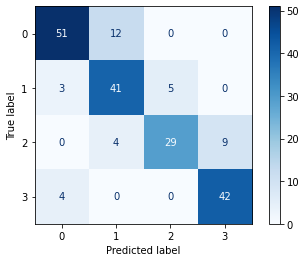

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

matrix = confusion_matrix(y_test_all, y_pred_all)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=['0', '1', '2', '3'])
matrix_display.plot(cmap='Blues')

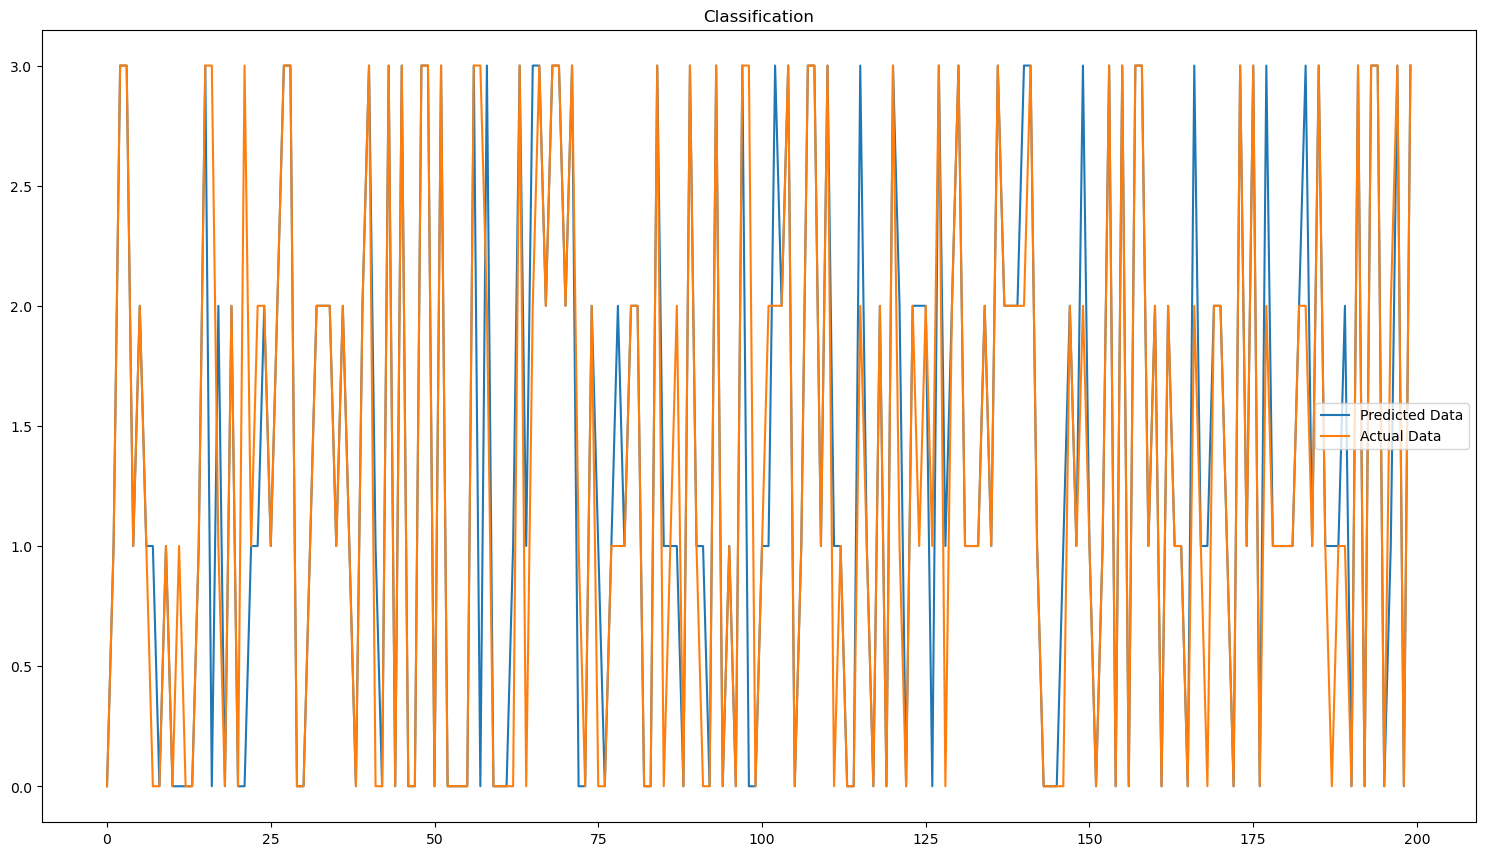

In [46]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

plt.plot(y_pred_all, label='Predicted Data') # predicted plot
plt.plot(y_test_all, label='Actual Data') # actual plot
plt.title('Classification')
plt.legend()
plt.show() 

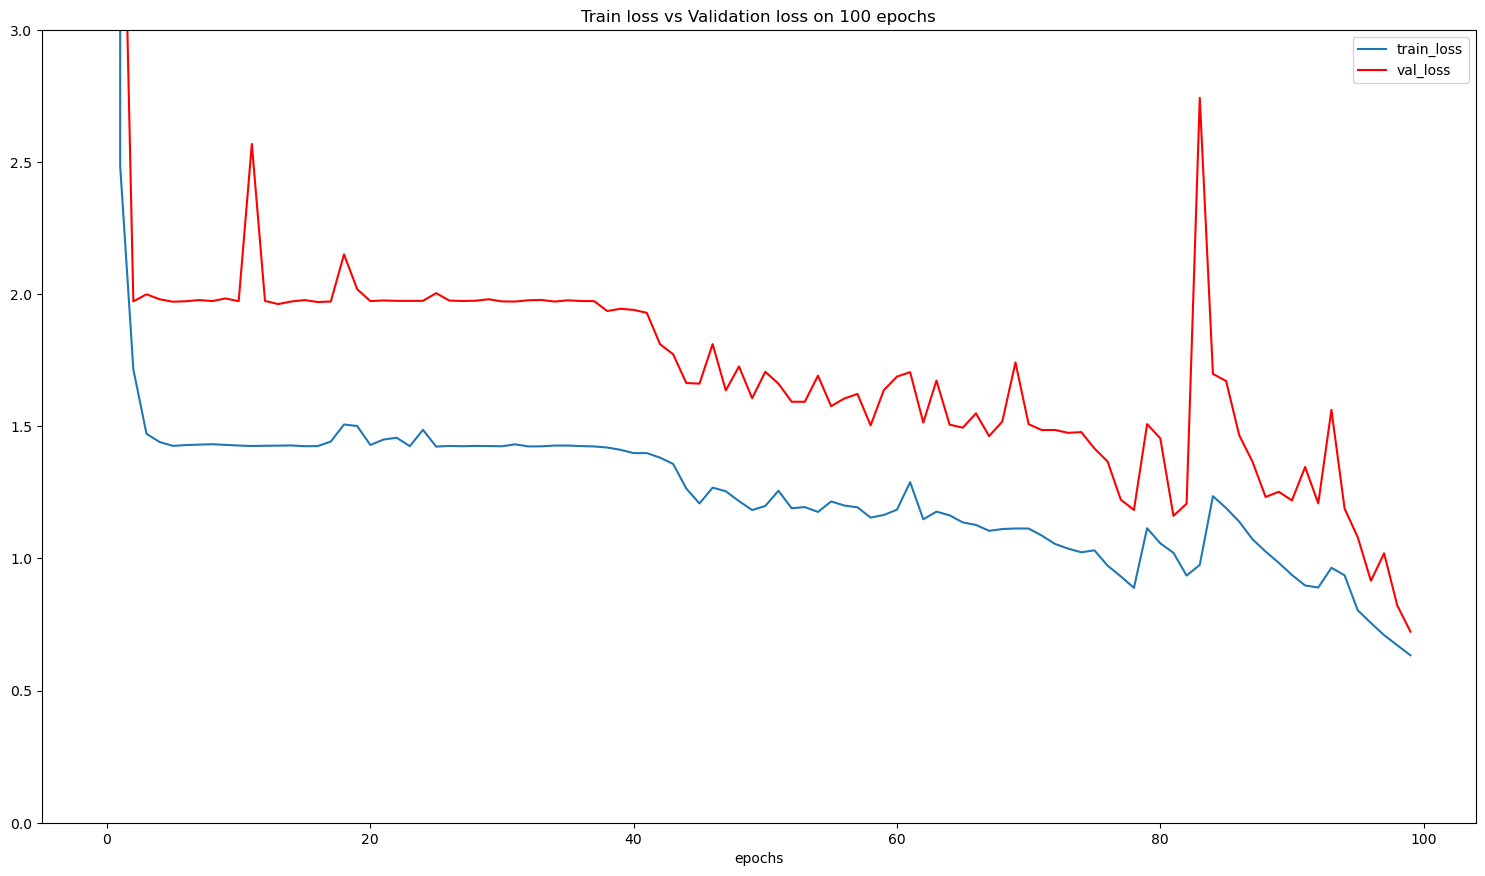

In [47]:

def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    plt.ylim([0, 3])
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_validation)

[24.753086419753085, 27.34567901234568, 26.049382716049386, 25.617283950617285, 25.864197530864196, 25.0, 23.08641975308642, 27.098765432098766, 25.98765432098765, 23.827160493827158, 25.0, 24.074074074074073, 24.938271604938272, 24.87654320987654, 23.950617283950617, 24.444444444444443, 25.0, 23.88888888888889, 24.074074074074073, 25.123456790123456, 24.62962962962963, 25.493827160493826, 24.135802469135804, 25.679012345679013, 24.567901234567902, 26.111111111111114, 25.679012345679013, 24.938271604938272, 25.74074074074074, 25.679012345679013, 24.753086419753085, 24.074074074074073, 25.061728395061728, 25.74074074074074, 22.839506172839506, 23.765432098765434, 24.938271604938272, 24.691358024691358, 26.97530864197531, 27.962962962962962, 27.901234567901234, 26.41975308641975, 31.35802469135803, 31.419753086419753, 42.407407407407405, 43.82716049382716, 40.617283950617285, 42.839506172839506, 40.67901234567901, 44.074074074074076, 40.925925925925924, 42.839506172839506, 44.25925925925

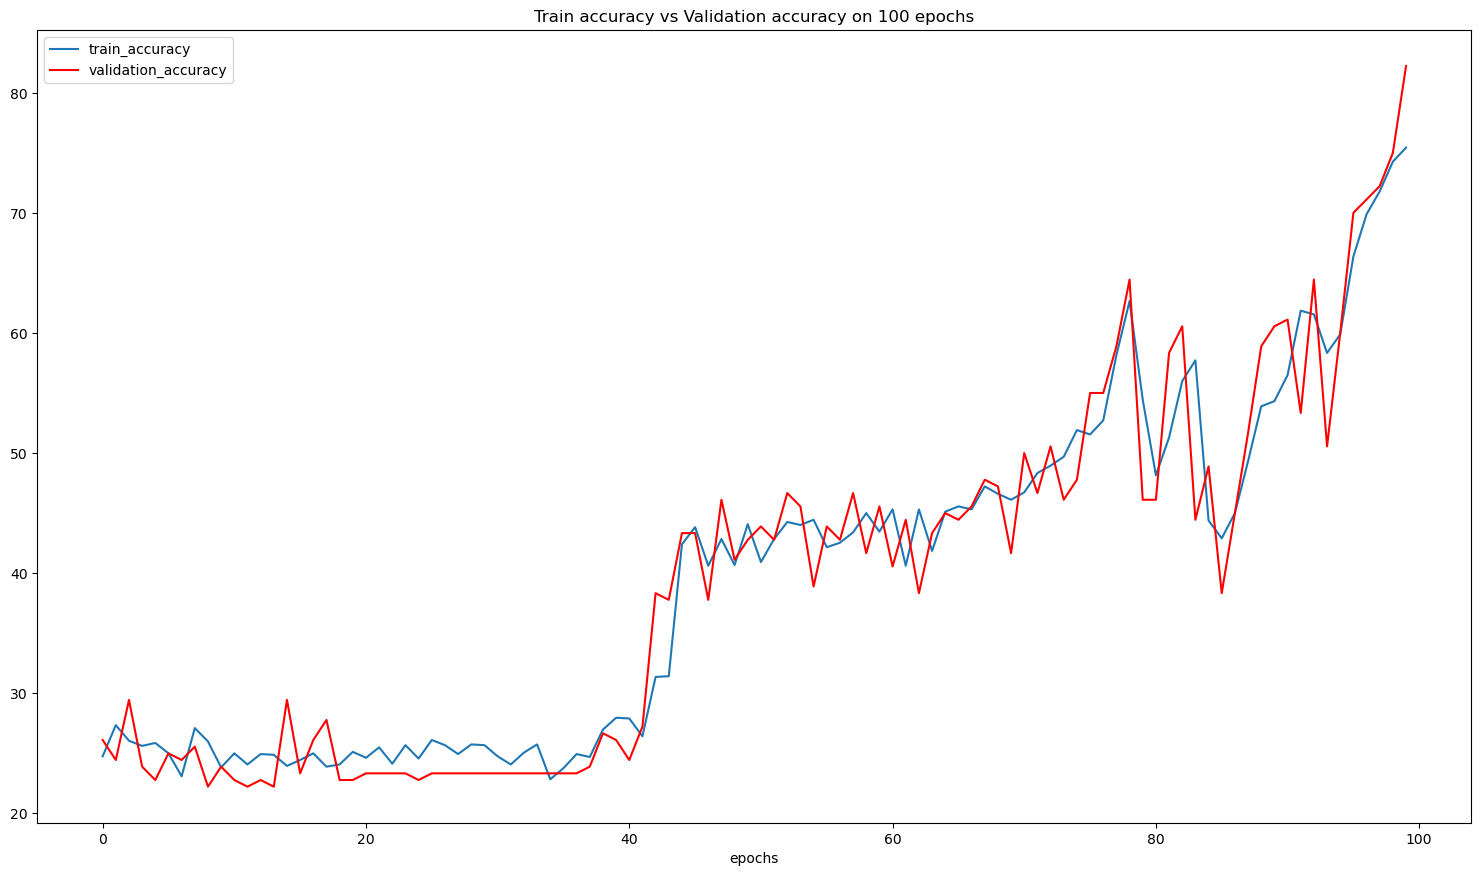

In [49]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train accuracy vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

print(accuracy_train, accuracy_validation)
plot_accuracy(accuracy_train, accuracy_validation)